In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Pooja/COVID DL/Final_project

/content/drive/My Drive/Pooja/COVID DL/Final_project


# Importing Libraries

In [ ]:
# dataset preparation for segmentation
#%% Training  file
# Run this cell if running this notebook for the first time

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Name experiment
experiment_name = "exp-5"

# Import Standard dependencies
import matplotlib.pyplot as plt
import matplotlib.colors
import random
import cv2
import numpy as np

# Import Machine Learning lib
import keras.backend as K
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Add, MaxPooling2D
from keras.layers import Input, Dropout, BatchNormalization, Activation, LeakyReLU
from keras.layers.merge import concatenate, add
from keras import Model
from keras.optimizers import Adam


# Data Preparation

Get the prepared dataset path

In [ ]:
def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
# Define paths
dataset_name = "."
base_path = os.path.abspath(".")
dataset_path = os.path.join(base_path, dataset_name)
dataset_path = base_path
path=os.path.join(dataset_path,'datacovd19')
log_path = os.path.join(path,"log", experiment_name)

In [ ]:
print(dataset_path)
print(base_path)
print(log_path)
print(os.path.join(dataset_path,'datacovd19','train', 'images'))

/content/drive/My Drive/Pooja/COVID DL/Final_project
/content/drive/My Drive/Pooja/COVID DL/Final_project
/content/drive/My Drive/Pooja/COVID DL/Final_project/datacovd19/log/exp-5
/content/drive/My Drive/Pooja/COVID DL/Final_project/datacovd19/train/images


Get the training, validation and testing data

In [ ]:
log_path = os.path.join(path, "logs", experiment_name)
patchsize = 256


# For full data training
full_data_path = os.path.join(base_path)

print(log_path)
print(os.listdir(dataset_path))


# Make directory
create_directory(log_path)


# Get the data

# Training data
x_train_dir = os.path.join(dataset_path,'datacovd19', 'train', 'images')
y_train_dir = os.path.join(dataset_path,'datacovd19', 'train', 'masks')

# Validation data
x_valid_dir = os.path.join(dataset_path,'datacovd19', 'val', 'images')
y_valid_dir = os.path.join(dataset_path,'datacovd19' ,'val', 'masks')

# Test data
x_test_dir = os.path.join(dataset_path,'datacovd19', 'test', 'images')
y_test_dir = os.path.join(dataset_path,'datacovd19' ,'test', 'masks')

print("Training and validation samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir)))

/content/drive/My Drive/Pooja/COVID DL/Final_project/datacovd19/logs/exp-5
['datacovd19-20200602T122320Z-001.zip', 'datacovd19']
Training and validation samples:  2840 680


Visualize module for visualizing the dataset clearly each label seperately

In [ ]:
#Dataloader and utility functions
    
# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue"])

    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
# Helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

Loading data in multi-label format

In [ ]:
# Classes for data loading and preprocessing
class Dataset:
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['RightLung', 'LeftLung', 'Disease', 'unlabelled']

    
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        
        # Sorted
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_dir, image_id) for image_id in self.ids])

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes] # cls used instead of cls.lower()

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.masks_fps[i], 0)  
        
        # Extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

Visualizing a sample of prepared data 

(256, 256, 3) (256, 256, 4)


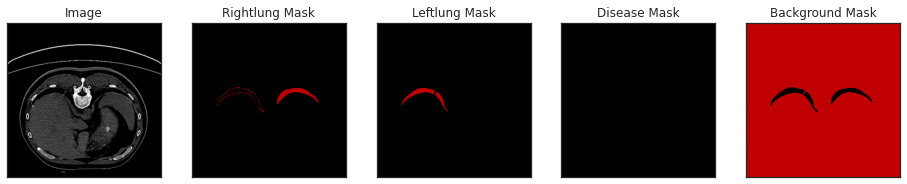

(256, 256, 3) (256, 256, 4)


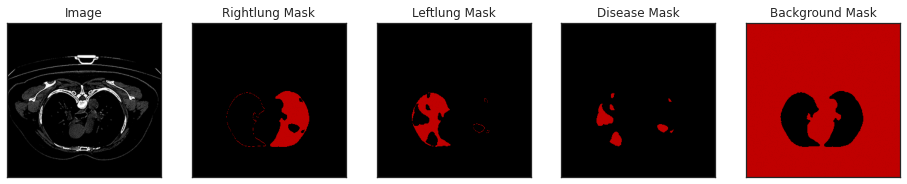

(256, 256, 3) (256, 256, 4)


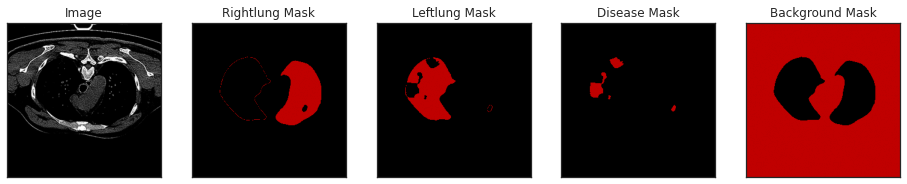

(256, 256, 3) (256, 256, 4)


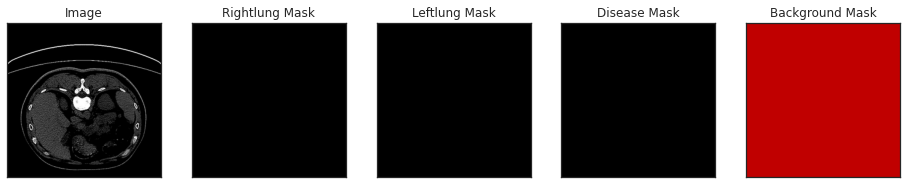

(256, 256, 3) (256, 256, 4)


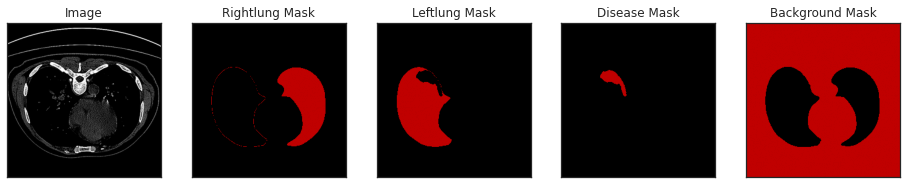

In [ ]:
med= ['RightLung', 'LeftLung', 'Disease']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)

for i in range(5):
    
    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)
    
    visualize(
    image=image, 
    RightLung_mask = mask[..., 1].squeeze(),
    LeftLung_mask = mask[..., 2].squeeze(),
    Disease_mask = mask[..., 3].squeeze(),
    background_mask = mask[..., 0].squeeze(),
    )

Some augmentation modules

In [ ]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=patchsize, width=patchsize, always_apply=True), # patchsize instead of 320
        A.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 96"""
    test_transform = [
        A.PadIfNeeded(patchsize, patchsize)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

Forming training and validation dataset for training the deep learning model

In [ ]:
n_classes=4
CLASSES=med
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES ,
    augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)


Checking whether it is loaded in correct format or not.

In [ ]:
BATCH_SIZE=8
train_dataloader = Dataloder(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
BATCH_SIZE=8
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
EPOCHS=100
# Test train loader
x , y = next(iter(train_dataloader))
print(x.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256, 4)


# Deep Learning Model (Multi-Residual UNET)

## Defining Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

def Dice_coef(y_true, y_pred, smooth = 1):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
 
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def Dice_loss(y_true, y_pred):   
    return  1.0 - Dice_coef(y_true, y_pred) 
    

## Model Architecture

### Defining modules for the Multi-Residual UNET

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False, kernel_regularizer=regularizers.l1_l2(0.0001, 0.0001))(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if (activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


def MultiResBlock(U, inp, alpha=1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W * 0.167) + int(W * 0.333) +
                         int(W * 0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W * 0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W * 0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W * 0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


    
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding, kernel_regularizer=regularizers.l1_l2(0.00001, 0.00001))(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(num_filters, blockInput):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = convolution_block(shortcut, filters, 1, 1,
                          padding='same', activation=False)

    out = convolution_block(inp, filters, (3, 3), padding='same',  activation=True)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length - 1):
        shortcut = out
        shortcut = convolution_block(shortcut, filters, (1, 1),
                             padding='same', activation=False)

        out = convolution_block(out, filters, (3, 3), padding='same',  activation=True)

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out

### Multi-Residual UNET module

In [ ]:

def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''

    inputs = Input((height, width, n_channels))

    mresblock1 = Conv2D(32, (3, 3), activation=None, padding="same")(inputs)
    mresblock1 = residual_block(32, mresblock1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = Conv2D(32*2, (3, 3), activation=None, padding="same")(pool1)
    mresblock2 = residual_block(32*2, mresblock2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    pool2 = Dropout(0.5)(pool2)
    mresblock2 = ResPath(32 * 2, 3, mresblock2)
    
    mresblock3 = Conv2D(32*4, (3, 3), activation=None, padding="same")(pool2)
    mresblock3 = residual_block(32*4, mresblock3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32 * 4, 2, mresblock3)

    mresblock4 = Conv2D(32*8, (3, 3), activation=None, padding="same")(pool3)
    mresblock4 = residual_block(32*8, mresblock4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    pool4 = Dropout(0.5)(pool4)
    mresblock4 = ResPath(32 * 8, 1, mresblock4)

    mresblock5 = Conv2D(32*16, (3, 3), activation=None, padding="same")(pool4)
    mresblock5 = residual_block(32*16, mresblock5)
    mresblock5 = Dropout(0.5)(mresblock5)

    up6 = concatenate([Conv2DTranspose(
        32 * 8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32 * 8, up6)

    up7 = concatenate([Conv2DTranspose(
        32 * 4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32 * 4, up7)

    up8 = concatenate([Conv2DTranspose(
        32 * 2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32 * 2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = Conv2D(4, 1, activation='softmax')(mresblock9)
    

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-4), loss=Combo_Loss, metrics=[Dice_coef])

    return model

In [ ]:
K.clear_session()
img_size = 256
model = MultiResUnet(img_size,256,3)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

# Training the model

Defining various callbacks for training

In [ ]:
BATCH_SIZE = 8
CLASSES =['RightLung', 'LeftLung', 'Disease']
EPOCHS = 100

# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(log_path, experiment_name), monitor='val_Dice_coef', save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_Dice_coef', factor=0.1, verbose=1, patience=5, mode='max'), ## new_lr = lr * factor # 5
    keras.callbacks.EarlyStopping(monitor='val_Dice_coef', min_delta=0, verbose=1, patience=15, mode='max', restore_best_weights=True), # 8
    keras.callbacks.CSVLogger('{}/training.csv'.format(log_path))
]

Checking the presence of GPU

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Training

In [ ]:
start_time = time.time()


history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),  # val samples = batch size * no of steps
)

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

Epoch 1/100
355/355 [==============================] - 432s 1s/step - loss: 3.0113 - Dice_coef: 0.6952 - val_loss: 1.6801 - val_Dice_coef: 0.7979
Epoch 2/100
355/355 [==============================] - 412s 1s/step - loss: 1.0935 - Dice_coef: 0.8841 - val_loss: 0.8578 - val_Dice_coef: 0.8816
Epoch 3/100
355/355 [==============================] - 411s 1s/step - loss: 0.6142 - Dice_coef: 0.9163 - val_loss: 0.6345 - val_Dice_coef: 0.9008
Epoch 4/100
355/355 [==============================] - 410s 1s/step - loss: 0.4400 - Dice_coef: 0.9331 - val_loss: 0.4892 - val_Dice_coef: 0.9118
Epoch 5/100
355/355 [==============================] - 410s 1s/step - loss: 0.3572 - Dice_coef: 0.9426 - val_loss: 0.4191 - val_Dice_coef: 0.9129
Epoch 6/100
355/355 [==============================] - 411s 1s/step - loss: 0.3111 - Dice_coef: 0.9486 - val_loss: 0.3298 - val_Dice_coef: 0.9375
Epoch 7/100
355/355 [==============================] - 410s 1s/step - loss: 0.2597 - Dice_coef: 0.9580 - val_loss: 0.3547 - 

Plot of training & validation accuracy and loss graph while training

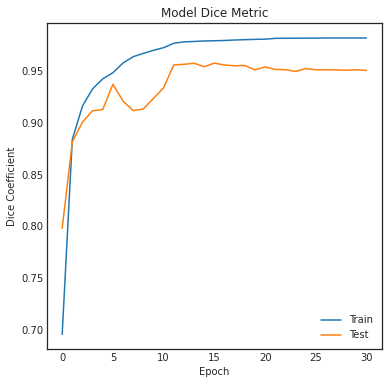

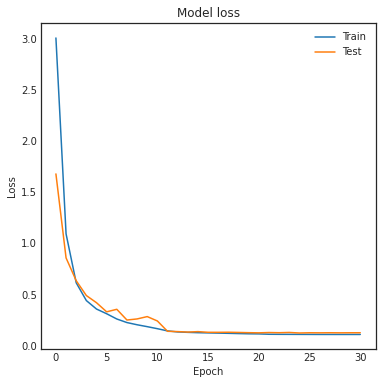

In [ ]:
# Plot training & validation accuracy values
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['Dice_coef'])
plt.plot(history.history['val_Dice_coef'])
plt.title('Model Dice Metric')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# **Testing the model**

In [ ]:
model.load_weights('{}/{}.h5'.format(log_path, experiment_name))

In [ ]:
dataset_test = Dataset(x_test_dir, y_test_dir, classes=med)
b = len(dataset_test)
test_data = Dataloder(dataset_test, batch_size=170, shuffle=True)
test_data_x, test_data_y = next(iter(test_data))
print(test_data_x.shape, test_data_y.shape)

(170, 256, 256, 3) (170, 256, 256, 4)


In [ ]:
y_pred = model.predict(test_data_x.reshape((-1,256,256,3)))
preds = np.argmax(y_pred.squeeze(), axis=-1)

In [ ]:
y_pred.shape

(170, 256, 256, 4)

In [ ]:
def get_mask(y_pred, classes):
    CLASSES = ['RightLung', 'LeftLung', 'Disease', 'unlabelled']
    # convert str names to class values on masks
    class_values = [CLASSES.index(cls) for cls in classes] # cls used instead of cls.lower()
    pred_mask = np.empty((0,y_pred.shape[1],y_pred.shape[2],4))

    for i in range(y_pred.shape[0]):
        mask = y_pred[i]
        # Extract certain classes from mask
        masks = [(mask == v) for v in class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        pred_mask = np.append(pred_mask, [mask], axis = 0)

    return pred_mask

In [ ]:
pred_masks = get_mask(preds, classes = med)
pred_masks.shape

(170, 256, 256, 4)

## Visualizations

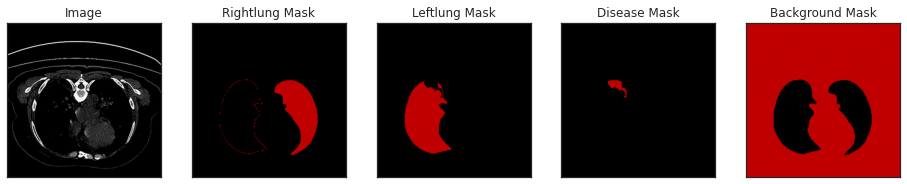

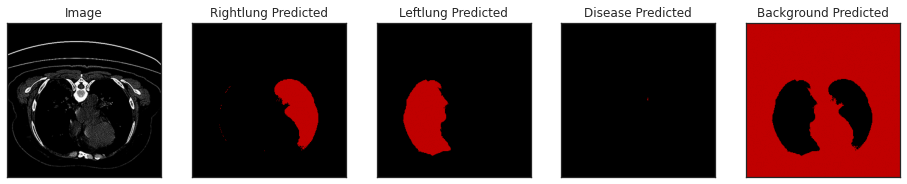

In [ ]:
# test_data_x, test_data_y
# pred_masks
i = 5
 
visualize(
    image=test_data_x[i], 
    RightLung_mask = test_data_y[i][..., 1].squeeze(),
    LeftLung_mask = test_data_y[i][..., 2].squeeze(),
    Disease_mask = test_data_y[i][..., 3].squeeze(),
    background_mask = test_data_y[i][..., 0].squeeze(),
)

visualize(
    image=test_data_x[i], 
    RightLung_predicted = pred_masks[i][..., 1].squeeze(),
    LeftLung_predicted = pred_masks[i][..., 2].squeeze(),
    Disease_predicted = pred_masks[i][..., 3].squeeze(),
    background_predicted = pred_masks[i][..., 0].squeeze(),
)

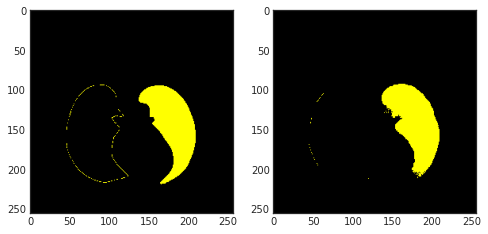

In [ ]:
norm=plt.Normalize(0,3) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "yellow","blue","red"])
i = 5
f, axarr = plt.subplots(1,2, figsize=(8,8))

axarr[0].imshow(test_data_y[i][..., 1], cmap=map_name, norm=norm)
axarr[1].imshow(pred_masks[i][..., 1], cmap=map_name, norm=norm)

# Various Metrics for Performance Evaluation

##Dice Coefficients and Hausdorff Distance

In [ ]:
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import average_precision_score, accuracy_score
dice = dict()
haus_d = dict()
Acc = dict()
j = 5
for i in range(4):
    Acc[i] = average_precision_score(K.flatten(test_data_y[j][..., i]), K.flatten(pred_masks[j][..., i]))
    print('Average Precision score for class %d:'%i)
    print(Acc[i])
    dice[i] = Dice_coef((test_data_y[j][..., i]), (pred_masks[j][..., i]))
    print('Dice Coeff for class %d:'%i)
    tf.print(dice[i])
    haus_d[i],_,_ = directed_hausdorff((test_data_y[j][..., i]), (y_pred[j][..., i]))
    print('Hausdorff distance for class %d:'%i)
    print(haus_d[i])
    print('\n')

dice = Dice_coef((test_data_y[j]), (pred_masks[j]))
print('Overall Dice similarity Coefficient:')
tf.print(dice)


Average Precision score for class 0:
0.9922680538838068
Dice Coeff for class 0:
0.98963568128797863
Hausdorff distance for class 0:
4.350813988891496


Average Precision score for class 1:
0.8466036756421788
Dice Coeff for class 1:
0.91708000862626693
Hausdorff distance for class 1:
3.8528655269665677


Average Precision score for class 2:
0.870430970951522
Dice Coeff for class 2:
0.93076390491576277
Hausdorff distance for class 2:
4.426527505366494


Average Precision score for class 3:
0.0052947998046875
Dice Coeff for class 3:
0.0028248587570621469
Hausdorff distance for class 3:
4.397445876411397


Overall Dice similarity Coefficient:
0.97599810792459163


##                        ROC & AUC Curves

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])


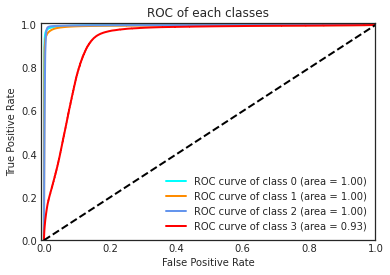

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()    

## A Bland–Altman plot

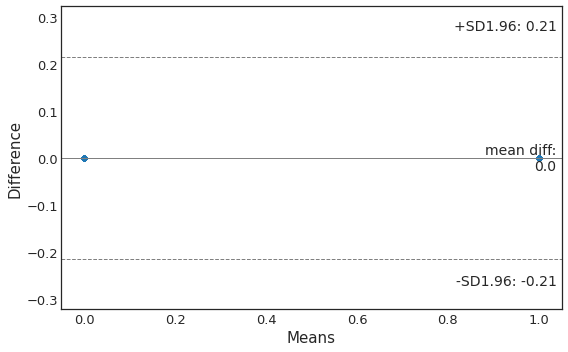

In [ ]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(K.flatten(test_data_y[5]), K.flatten(pred_masks[5]), ax = ax)

plt.show()

## Pearson correlation coefficients & Dice Similarity Coefficients

In [ ]:
from scipy.stats import pearsonr

for i in range(4):
  corr, _ = pearsonr(K.flatten(test_data_y[..., i]), K.flatten(pred_masks[..., i]))
  print('Pearsons correlation coefficients for class {0}: {1:0.4f}' ''.format(i, corr))

Pearsons correlation coefficients for class 0: 0.9305
Pearsons correlation coefficients for class 1: 0.9050
Pearsons correlation coefficients for class 2: 0.8886
Pearsons correlation coefficients for class 3: 0.0166


In [ ]:
for i in range(4):
  dice = Dice_coef((test_data_y[..., i]), (pred_masks[..., i]))
  print('Dice Coeff for class %d:'%i)
  tf.print(dice)

Dice Coeff for class 0:
0.9936649388255675
Dice Coeff for class 1:
0.90847104498136211
Dice Coeff for class 2:
0.88911492851959872
Dice Coeff for class 3:
0.0050972777176145484
